In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors
import gensim
from gensim.models import Word2Vec
from io import BytesIO
from PIL import Image
import requests
from gensim.similarities import Similarity
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
df_tv = pd.read_csv('/content/drive/MyDrive/tv_shows.csv')
df_tv = df_tv[df_tv['Description'] != "We don't have an overview translated in English. Help us expand our database by adding one."]
df_tv = df_tv.reset_index(drop=True)
df_tv.head()

,Title,Description,Img_Link
0,Ulice,Ulice is a Czech soap opera produced and broad...,https://www.themoviedb.org/t/p/w220_and_h330_f...
1,Wednesday,"Wednesday Addams is sent to Nevermore Academy,...",https://www.themoviedb.org/t/p/w220_and_h330_f...
2,Questions pour un champion,"Samuel Etienne hosts this emblematic game, whi...",https://www.themoviedb.org/t/p/w220_and_h330_f...
3,The Last of Us,Twenty years after modern civilization has bee...,https://www.themoviedb.org/t/p/w220_and_h330_f...
4,Tulsa King,Just after he is released from prison after 25...,https://www.themoviedb.org/t/p/w220_and_h330_f...


In [19]:
df_movie = pd.read_excel('/content/drive/MyDrive/IMDB_Dataset.xlsx').drop(columns=['Unnamed: 0'])
df_movie.head()

,Movie,ImgLink,Description
0,Project Power,https://m.media-amazon.com/images/M/MV5BYzBhOW...,When a pill that gives its users unpredictable...
1,The Tax Collector,https://m.media-amazon.com/images/M/MV5BMmFmZT...,"A ""tax collector"" working for a local crime lo..."
2,Perry Mason,https://m.media-amazon.com/images/M/MV5BMDllMW...,"In booming 1932 Los Angeles, a down-and-out de..."
3,Yellowstone,https://m.media-amazon.com/images/M/MV5BZjhkNW...,A ranching family in Montana faces off against...
4,Dark,https://m.media-amazon.com/images/M/MV5BZmY2Yz...,"A family saga with a supernatural twist, set i..."


In [20]:
def prep(x): #string
    processed_text = x.lower()
    processed_text = re.sub('[^a-zA-Z]', ' ', processed_text)
    processed_text = re.sub(r'\s+', ' ', processed_text)
    word_tokens = word_tokenize(processed_text)
    return word_tokens

def remove_stopping(x):#list
    removed_list = [w for w in x if not w in stopwords.words('english')]
    return removed_list
    
def prep_on_df(df, column):
    all_desc = []
    for i in range(0, len(df)):
        text = df[column][i]
        res = remove_stopping(prep(text))
        all_desc.append(res)
    return all_desc

def get_all_vocab(sentences):
  corpus = []
  corpus_unencoded = []
  for sentence in sentences:
    for word in sentence:
      if (word not in corpus_unencoded):
        corpus_unencoded.append(word)
        corpus.append(word.encode('utf-8').split())
  return corpus, corpus_unencoded

all_desc_movie = prep_on_df(df_movie, 'Description')
corpus, corpus_unencoded = get_all_vocab(all_desc_movie)
corpus_unencoded=[corpus_unencoded]
print(len(corpus))

19233


In [22]:
all_desc_tv = prep_on_df(df_tv, 'Description')
all_desc = all_desc_movie + all_desc_tv
len(all_desc)

12489

In [14]:
path = '/content/drive/MyDrive/project_data/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(path, binary=True)
print("vocab_size:",len(model.vocab.keys()))

vocab_size: 3000000


In [15]:
google_model = Word2Vec(size=300, window=5, min_count = 2, sg=1)
google_model.build_vocab(sentences=all_desc)
google_model.intersect_word2vec_format(path, lockf=1.0, binary=True)
print(len(google_model.wv.vocab))
google_model.train(sentences=all_desc, total_examples = google_model.corpus_count, epochs = 7)

13959


(1455330, 1562421)

In [16]:
google_model.most_similar(positive=['water'])

<ipython-input-16-c5bf63939464>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  google_model.most_similar(positive=['water'])


[('lake', 0.5949653387069702),
 ('river', 0.5777886509895325),
 ('supply', 0.5680469870567322),
 ('electricity', 0.5590593814849854),
 ('rivers', 0.557060956954956),
 ('lagoon', 0.5334475636482239),
 ('thirsty', 0.5273942947387695),
 ('creek', 0.5273407697677612),
 ('drinking', 0.5242946743965149),
 ('fish', 0.5222858190536499)]

In [18]:
def get_avg_vec(sentences, model):
  all_sen_vec = []
  for sentence in sentences:
    count = 0
    sen_vec = np.zeros(model.vector_size)
    for word in sentence:
      if word in model.wv.vocab:
        sen_vec = sen_vec + model[word]
        count = count + 1
    avg_vec = sen_vec/count
    all_sen_vec.append(avg_vec)
  return all_sen_vec, len(all_sen_vec)

all_sen_vec, all_sen_len = get_avg_vec(all_desc, google_model)
print(all_sen_len)

<ipython-input-18-d8e9d438412d>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sen_vec = sen_vec + model[word]


12489


In [23]:
def cosine_similarity(x, y):
  return (np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)))

def recommendations(movie, movies_df, all_sen_vec=all_sen_vec):
  df_movie = movies_df.loc[movies_df.Movie==movie]
  index = df_movie.index[0]
  movie_vec1 = all_sen_vec[index]
  size = len(movies_df)
  top_simil = {}
  for i in range(0, size):
    if i==index:
      continue
    else:
      movie_vec2 = all_sen_vec[i]
      simil = cosine_similarity(movie_vec1, movie_vec2)
      top_simil[i] = simil
  top_simil = dict(sorted(top_simil.items(), key=lambda item: item[1], reverse=True))
  top_simil_index = list(top_simil.keys())
  top_5 = top_simil_index[0:5]
  return top_5

print(recommendations(movie = 'Yellowstone', movies_df = df_movie))

[7880, 3993, 3216, 7630, 2207]


In [24]:
def show_recommend(rec, movie_df):
  rec_df = movie_df.iloc[rec]
  for index, row in rec_df.iterrows():
    response = requests.get(row['ImgLink'])
    img = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(img)
    plt.title(row['Movie'])
    plt.show()
    print(row['Description'])

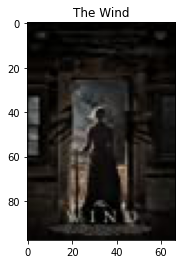

A plains-woman faces the harshness and isolation of the untamed land in the Western frontier of the late 1800s.


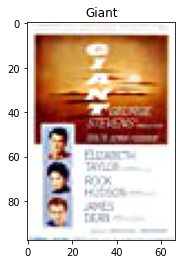

Sprawling epic covering the life of a Texas cattle rancher and his family and associates.


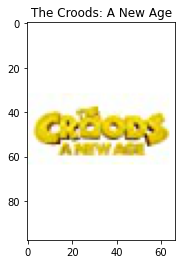

The prehistoric family the Croods are challenged by a rival family the Bettermans, who claim to be better and more evolved.


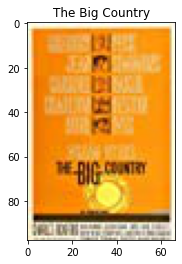

A New Englander arrives in the Old West, where he becomes embroiled in a feud between two families over a valuable patch of land.


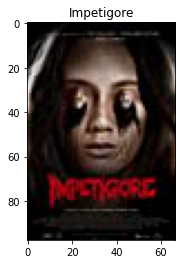

Maya with her best friend, Dini, tries to survive in a city without a family. She realized that she might inherit a property from her rich family. Maya returns to the village with Dini and unaware of the danger was waiting for her.


In [26]:
show_recommend(recommendations('Yellowstone', df_movie), df_movie)

In [27]:
def get_tf(word, sentence):
  a = len(sentence)
  b = 0
  for w in sentence:
    if w==word:
      b = b + 1
  return b/a

def get_idf(word, sentences):
  a = len(sentences)
  b = 0
  for sentence in sentences:
    if word in sentence:
      b = b + 1
  return np.log(a/b)

def get_tf_idf(word, sentence, sentences):
  return get_tf(word, sentence) * get_idf(word, sentences)

In [28]:
def get_avg_tfidf_vec(sentences, model):
  all_sen_vec = []
  for sentence in sentences:
    count = 0
    sen_vec = np.zeros(model.vector_size)
    for word in sentence:
      if word in model.wv.vocab:
        sen_vec = sen_vec + model[word] * get_tf_idf(word, sentence, sentences)
        count = count + 1
    avg_vec = sen_vec/count
    all_sen_vec.append(avg_vec)
  return all_sen_vec, len(all_sen_vec)

all_sen_tfidf_vec, all_sen_tfidf_len = get_avg_tfidf_vec(all_desc, google_model)

<ipython-input-28-4d474021ac6e>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sen_vec = sen_vec + model[word] * get_tf_idf(word, sentence, sentences)


In [29]:
def recommendations_tfidf(movie, movies_df, all_sen_vec2=all_sen_tfidf_vec):
  df_movie = movies_df.loc[movies_df.Movie==movie]
  index = df_movie.index[0]
  movie_vec1 = all_sen_vec2[index]
  size = len(movies_df)
  top_simil = {}
  for i in range(0, size):
    if i==index:
      continue
    else:
      movie_vec2 = all_sen_vec2[i]
      simil = cosine_similarity(movie_vec1, movie_vec2)
      top_simil[i] = simil
  top_simil = dict(sorted(top_simil.items(), key=lambda item: item[1], reverse=True))
  top_simil_index = list(top_simil.keys())
  top_5 = top_simil_index[0:5]
  return top_5

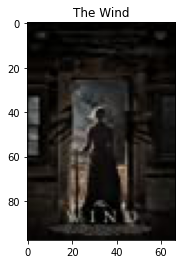

A plains-woman faces the harshness and isolation of the untamed land in the Western frontier of the late 1800s.


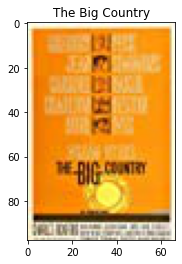

A New Englander arrives in the Old West, where he becomes embroiled in a feud between two families over a valuable patch of land.


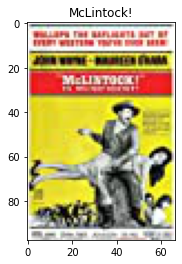

Wealthy rancher G.W. McLintock uses his power and influence in the territory to keep the peace between farmers, ranchers, land-grabbers, Indians and corrupt government officials.


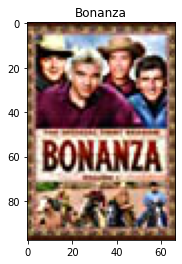

The Wild West adventures of Ben Cartwright and his sons as they run and defend their Nevada ranch while helping the surrounding community.


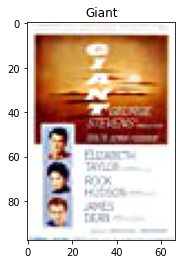

Sprawling epic covering the life of a Texas cattle rancher and his family and associates.


In [31]:
show_recommend(recommendations_tfidf('Yellowstone', df_movie), df_movie)

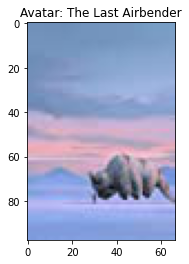

Live-action adaptation of the animated series centering on the adventures of Aang and his friends, who fight to save the world by defeating the Fire-Nation


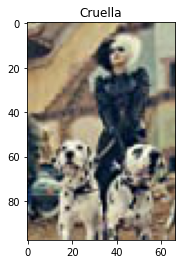

A live-action prequel feature film following a young Cruella de Vil.


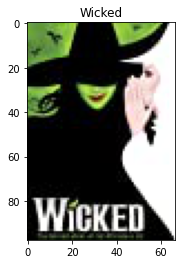

The story of how a green-skinned woman framed by the Wizard of Oz becomes the Wicked Witch of the West; feature film based on the Broadway musical.


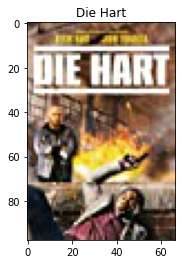

Kevin Hart plays a fictionalized version of himself on a quest to land the action-movie role of a lifetime.


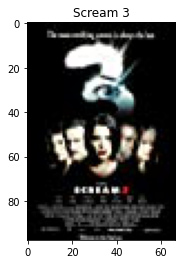

While Sidney and her friends visit the Hollywood set of Stab 3, the third film based on the Woodsboro murders, another Ghostface killer rises to terrorize them.


In [35]:
show_recommend(recommendations_tfidf('Mulan', df_movie), df_movie)